In [1]:
#Import libraries
import os
import tensorflow as tf
from PIL import Image, ImageChops, ImageEnhance
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [2]:
#Function to perform Error Level Analysis on image
def convert_to_ela_image(path, quality):
    temp_filename = 'temp_file_name.jpg'
    ela_filename = 'temp_ela.png'
    image = Image.open(path).convert('RGB')
    image.save(temp_filename, 'JPEG', quality = quality)
    temp_image = Image.open(temp_filename)

    ela_image = ImageChops.difference(image, temp_image)

    extrema = ela_image.getextrema()
    max_diff = sum([ex[1] for ex in extrema])/3
    if max_diff == 0:
        max_diff = 1

    scale = 255.0 / max_diff
    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)
    
    return ela_image

In [3]:
#Funtion to perform pre-processing: resize, normalisation and convert to ELA image
def prepare_image(image_path):
    return np.array(convert_to_ela_image(image_path, 90).resize((128,128))).flatten() / 255.0

In [5]:
# Load and preprocess the images
X = []
Y = []

Real_path = '/kaggle/input/casia-20-image-tampering-detection-dataset/CASIA2/Au'
Tampered_path = '/kaggle/input/casia-20-image-tampering-detection-dataset/CASIA2/Tp'

paths = [Real_path,Tampered_path] 

label = 0
for i in paths:
    print(f"Processing {i} Images:")
    for name in os.listdir(i):
        img_path = os.path.join(i,name)
        if img_path.endswith('.jpeg') or img_path.endswith('.jpg'):
            img = prepare_image(image_path=img_path)
            X.append(img)
            Y.append(label)
            if len(Y)%1000==0: 
                print(f"\tProcessed {len(Y)} images")
    label=1

Processing /kaggle/input/casia-20-image-tampering-detection-dataset/CASIA2/Au Images:
	Processed 1000 images
	Processed 2000 images
	Processed 3000 images
	Processed 4000 images
	Processed 5000 images
	Processed 6000 images
	Processed 7000 images
Processing /kaggle/input/casia-20-image-tampering-detection-dataset/CASIA2/Tp Images:
	Processed 8000 images
	Processed 9000 images


In [6]:
from tensorflow.keras.utils import to_categorical

X = np.array(X).astype("float64")
Y = to_categorical(Y, 2)
X = X.reshape(-1, 128, 128, 3)

In [7]:
#Flatten images as SMOTE works on 2D data
X_flattened = X.reshape(-1, 128 * 128 * 3)

#Import SMOTE(for performing oversampling on minority class i.e. tampered images) and RandomUnderSampler(for performing undersampling on majority class i.e. authentic images)
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

# Apply SMOTE to oversample the tampered class
smote = SMOTE(random_state=42)

# Apply RandomUnderSampler to undersample the authentic class
undersample = RandomUnderSampler(sampling_strategy={0: 5000, 1: 5000}, random_state=42)

pipeline = Pipeline([('smote', smote), ('undersample', undersample)])


In [8]:
X_resampled, Y_resampled = pipeline.fit_resample(X_flattened, Y)

In [9]:
# Display number of images in each category after resampling

authentic_count = np.sum(Y_resampled == 0)
tampered_count = np.sum(Y_resampled == 1)
print(f'Number of images in category 0 (authentic): {authentic_count}')
print(f'Number of images in category 1 (tampered): {tampered_count}')

Number of images in category 0 (authentic): 5000
Number of images in category 1 (tampered): 5000


In [10]:
# Reshape X_resampled back to image dimensions
X_resampled = X_resampled.reshape(-1, 128, 128, 3)

# Convert labels to categorical format
Y_resampled = to_categorical(Y_resampled, 2)


In [11]:
from sklearn.utils import shuffle

# Shuffle X and Y together
X_resampled, Y_resampled = shuffle(X_resampled, Y_resampled, random_state=42)


# Split into train_validation, and test sets
X_test = X_resampled[:5000]
Y_test = Y_resampled[:5000]
X_train_val = X_resampled[5000:]
Y_train_val = Y_resampled[5000:]


In [12]:
#Save pre-processed data
os.makedirs('ELA_Data', exist_ok=True)

np.save('ELA_Data/X', X)
np.save('ELA_Data/Y', Y)
np.save('ELA_Data/X_test', X_test)
np.save('ELA_Data/Y_test', Y_test)

In [13]:
#Load data from .npy files(train_validation set)
X = np.load('ELA_Data/X.npy')
Y = np.load('ELA_Data/Y.npy')

In [14]:
#Split train_validation sets into train and validation sets
from sklearn.model_selection import train_test_split

X_train, X_val, Y_train, Y_val = train_test_split(X_train_val, Y_train_val, test_size=0.20, random_state=5)
X = X.reshape(-1,1,1,1)

In [15]:
#verify
print(len(X_train) , len(Y_train) )
print(len(X_val) , len(Y_val))
print(Y_val[:15])

4000 4000
1000 1000
[[0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]]


# DenseNet

In [16]:
from tensorflow.keras import Model, Sequential 
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.applications import DenseNet121

In [17]:
class Config:
    epochs = 30
    learning_rate = 1e-4
    model_name = 'densenet'
    n_labels = 2
    image_size = (128, 128)
    momentum = 0.95
    nesterov = False


In [18]:
METRICS = [
    tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
    tf.keras.metrics.AUC(name='auc')
]

In [19]:
base_model = DenseNet121(include_top=False, weights='imagenet', input_shape=(128, 128, 3))


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [20]:
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(1024, activation='relu')(x)
output = Dense(Config.n_labels, activation='softmax')(x)


In [21]:
model_dn = Model(inputs=base_model.inputs, outputs=output)

In [22]:
# Compile DenseNet model 
model_dn.compile(
    loss='categorical_crossentropy',
    optimizer=SGD(learning_rate=Config.learning_rate, momentum=Config.momentum, nesterov=Config.nesterov),
    metrics=METRICS
)


In [23]:
history_dnet = model_dn.fit(
    X_train, Y_train,
    epochs=30,
    batch_size=32,
    validation_data=(X_val, Y_val),
)

Epoch 1/30


I0000 00:00:1730361639.438571     133 service.cc:145] XLA service 0x7ce0680dfb90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730361639.438640     133 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1730361639.438645     133 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1730361694.840518     133 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


125/125 ━━━━━━━━━━━━━━━━━━━━ 124s 240ms/step - accuracy: 0.6520 - auc: 0.7058 - loss: 0.6287 - val_accuracy: 0.4850 - val_auc: 0.4642 - val_loss: 0.8985
Epoch 2/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 14s 108ms/step - accuracy: 0.9073 - auc: 0.9604 - loss: 0.2557 - val_accuracy: 0.5740 - val_auc: 0.6048 - val_loss: 0.8432
Epoch 3/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 14s 110ms/step - accuracy: 0.9290 - auc: 0.9826 - loss: 0.1811 - val_accuracy: 0.6720 - val_auc: 0.7938 - val_loss: 0.6193
Epoch 4/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 14s 112ms/step - accuracy: 0.9515 - auc: 0.9915 - loss: 0.1334 - val_accuracy: 0.8250 - val_auc: 0.9134 - val_loss: 0.3907
Epoch 5/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 14s 109ms/step - accuracy: 0.9682 - auc: 0.9958 - loss: 0.1004 - val_accuracy: 0.9070 - val_auc: 0.9591 - val_loss: 0.2630
Epoch 6/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 14s 109ms/step - accuracy: 0.9780 - auc: 0.9988 - loss: 0.0681 - val_accuracy: 0.9350 - val_auc: 0.9750 - val_loss: 0.1967
Epoch 7/30
125/125 ━━━━━━━━━━━━━

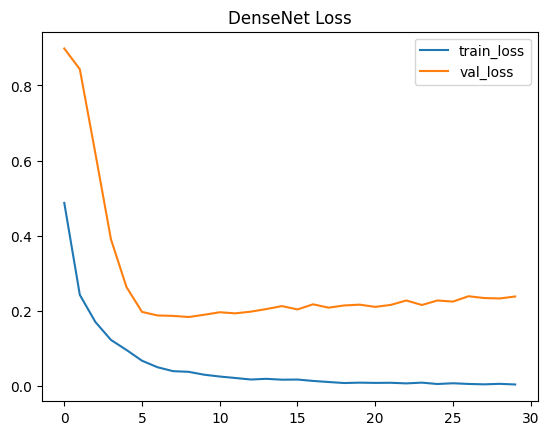

In [24]:
plt.plot(history_dnet.history['loss'])
plt.plot(history_dnet.history['val_loss'])
plt.title('DenseNet Loss')
plt.legend(['train_loss', 'val_loss'])
plt.show()

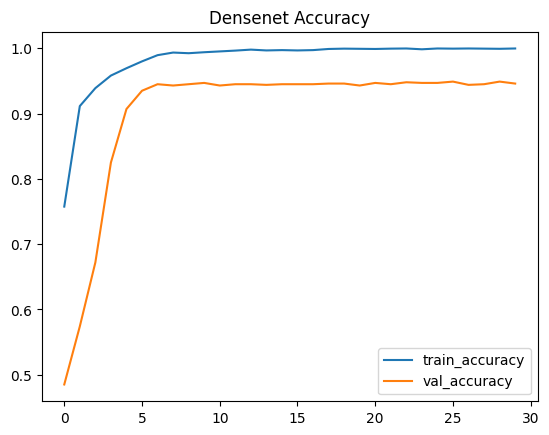

In [25]:
plt.plot(history_dnet.history['accuracy'])
plt.plot(history_dnet.history['val_accuracy'])
plt.title('Densenet Accuracy')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

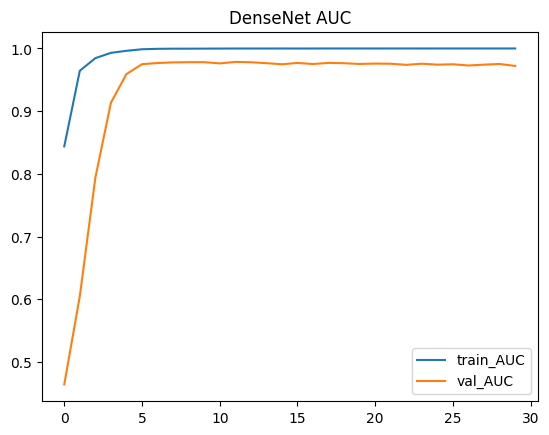

In [26]:
plt.plot(history_dnet.history['auc'])
plt.plot(history_dnet.history['val_auc'])
plt.title('DenseNet AUC')
plt.legend(['train_AUC', 'val_AUC'])
plt.show()

In [27]:
import itertools
from sklearn.metrics import roc_curve, roc_auc_score

#Function to plot confusion matrix for classification perofrmance evaluation 
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [28]:
X_test = np.load('ELA_Data/X_test.npy')
Y_test = np.load('ELA_Data/Y_test.npy')

In [ ]:
from sklearn.metrics import confusion_matrix

#predictions on the testing data 
Y_pred = model_dn.predict(X_test)

157/157 ━━━━━━━━━━━━━━━━━━━━ 21s 78ms/step


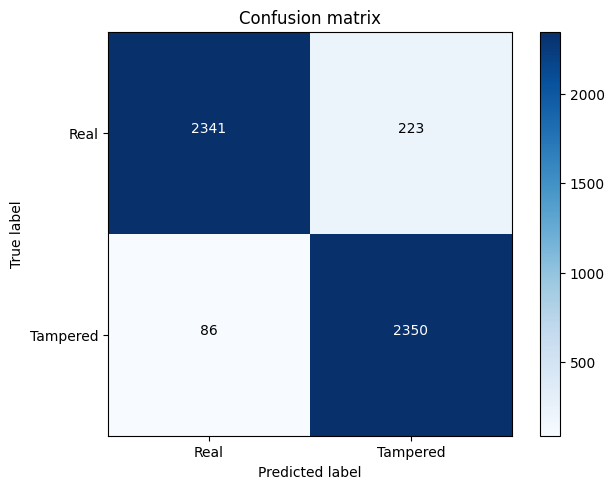

In [30]:
#argmax idx among class 0 and 1
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
Y_true = np.argmax(Y_test,axis = 1) 
densenet_confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
plot_confusion_matrix(densenet_confusion_mtx, classes = ['Real','Tampered'])

In [31]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt



1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


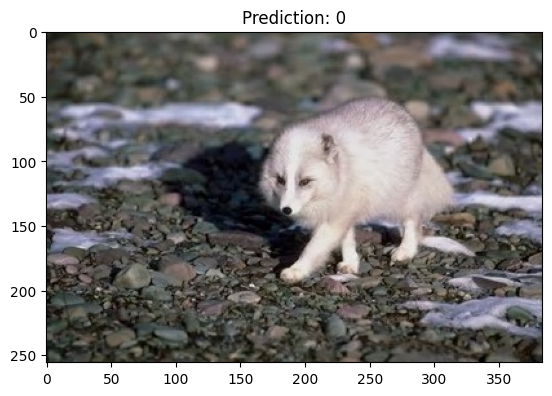

In [ ]:
image_path = '/kaggle/input/auauaua/au1.jpg'  
preprocessed_image = prepare_image(image_path)

# Reshape the preprocessed image to 128x128
preprocessed_image = preprocessed_image.reshape(1, 128, 128, 3)  

# Make predictions 
predictions = model_dn.predict(preprocessed_image)

# Display the image and prediction result
plt.imshow(Image.open(image_path))
plt.title(f"Prediction: {np.argmax(predictions)}")
plt.show()

In [35]:
model_dn.save('DN2_.h5')

# VGG

In [36]:
from keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Flatten, Dense, BatchNormalization


In [37]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [38]:
model_vgg = Sequential()
model_vgg.add(base_model)
model_vgg.add(Flatten())
model_vgg.add(Dense(256, activation='relu'))
model_vgg.add(Dense(2, activation='softmax'))




In [39]:
#Freeze the layers
for layer in base_model.layers:
    layer.trainable = False

In [41]:
# Compile the model
model_vgg.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])


In [42]:
model_vgg.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ ?                      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [43]:
from tensorflow.keras.callbacks import EarlyStopping

history_vgg = model_vgg.fit(X_train, Y_train, epochs=28, batch_size=32, validation_data=(X_val, Y_val), callbacks=[EarlyStopping(patience=2)])

Epoch 1/28
125/125 ━━━━━━━━━━━━━━━━━━━━ 23s 104ms/step - accuracy: 0.7223 - loss: 0.5459 - val_accuracy: 0.8460 - val_loss: 0.3362
Epoch 2/28
125/125 ━━━━━━━━━━━━━━━━━━━━ 7s 54ms/step - accuracy: 0.8598 - loss: 0.3250 - val_accuracy: 0.8700 - val_loss: 0.3157
Epoch 3/28
125/125 ━━━━━━━━━━━━━━━━━━━━ 7s 53ms/step - accuracy: 0.8839 - loss: 0.2842 - val_accuracy: 0.8810 - val_loss: 0.2901
Epoch 4/28
125/125 ━━━━━━━━━━━━━━━━━━━━ 7s 52ms/step - accuracy: 0.9075 - loss: 0.2511 - val_accuracy: 0.8270 - val_loss: 0.3622
Epoch 5/28
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 51ms/step - accuracy: 0.8932 - loss: 0.2662 - val_accuracy: 0.8910 - val_loss: 0.2661
Epoch 6/28
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 51ms/step - accuracy: 0.9169 - loss: 0.2322 - val_accuracy: 0.8920 - val_loss: 0.2597
Epoch 7/28
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 51ms/step - accuracy: 0.9136 - loss: 0.2380 - val_accuracy: 0.9000 - val_loss: 0.2615
Epoch 8/28
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 51ms/step - accuracy: 0.9158 - loss: 0.2201 - val_ac

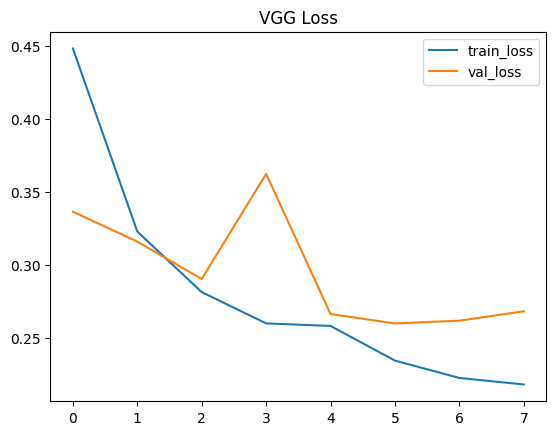

In [44]:
plt.plot(history_vgg.history['loss'])
plt.plot(history_vgg.history['val_loss'])
plt.title('VGG Loss')
plt.legend(['train_loss', 'val_loss'])
plt.show()

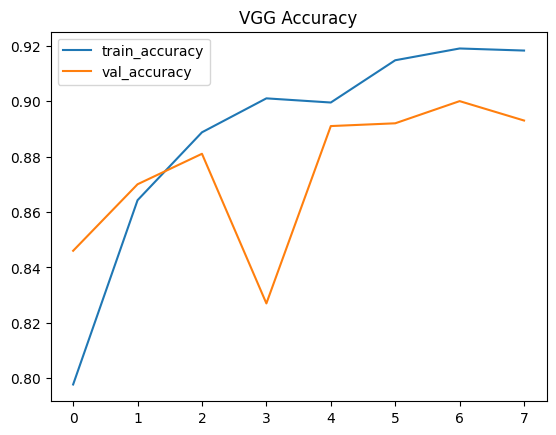

In [45]:
plt.plot(history_vgg.history['accuracy'])
plt.plot(history_vgg.history['val_accuracy'])
plt.title('VGG Accuracy')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

In [46]:
Y_pred = model_vgg.predict(X_test)

157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step


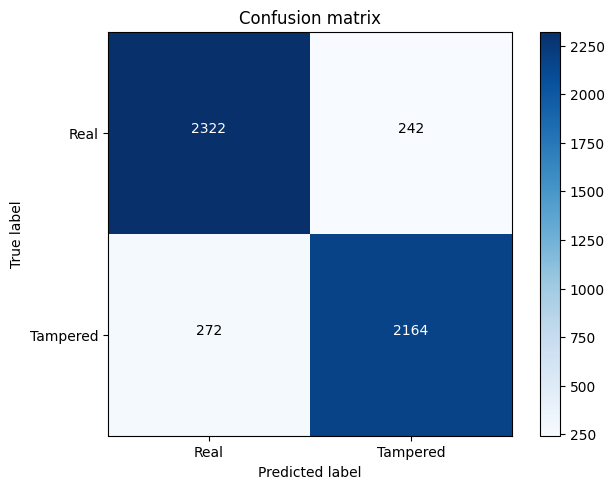

In [47]:
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
Y_true = np.argmax(Y_test,axis = 1) 
vgg_confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
plot_confusion_matrix(vgg_confusion_mtx, classes = ['Real','Tampered'])

# Efficientnet

In [48]:
from keras.applications import EfficientNetB4

In [49]:
base_model = EfficientNetB4(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

71686520/71686520 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [50]:
from tensorflow.keras.layers import Dropout

In [51]:
base_model.trainable = False

In [ ]:
x = base_model.output
x = GlobalAveragePooling2D()(x)  

# Fully connected layer
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x) 
x = Dropout(0.4)(x)  # Dropout for regularization

# Fully connected layer 
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

# Final output layer
output = Dense(2, activation='softmax')(x)


In [53]:
efficientnet_model = Model(inputs=base_model.input, outputs=output)

In [54]:
efficientnet_model.compile(optimizer=Adam(learning_rate=0.01), 
                           loss='categorical_crossentropy', 
                           metrics=['accuracy'])

In [55]:
history_ef =efficientnet_model .fit(
    X_train, Y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_val, Y_val), callbacks=[EarlyStopping(patience=1)]
)

Epoch 1/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 97s 171ms/step - accuracy: 0.4965 - loss: 1.0944 - val_accuracy: 0.5010 - val_loss: 0.8657
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.4942 - loss: 0.7898 - val_accuracy: 0.4990 - val_loss: 0.7832
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.4991 - loss: 0.8145 - val_accuracy: 0.4990 - val_loss: 0.6999
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.4879 - loss: 0.7425 - val_accuracy: 0.5010 - val_loss: 0.7003


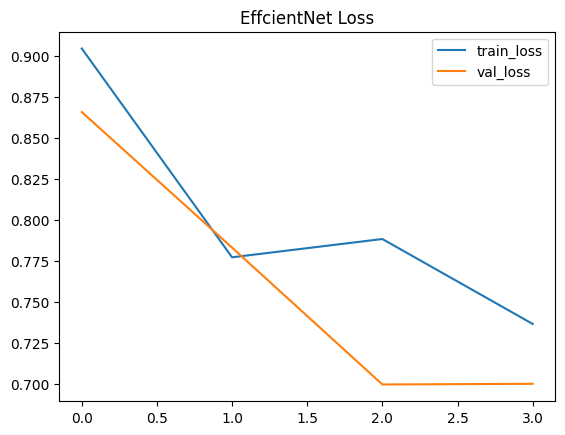

In [56]:
plt.plot(history_ef.history['loss'])
plt.plot(history_ef.history['val_loss'])
plt.title('EffcientNet Loss')
plt.legend(['train_loss', 'val_loss'])
plt.show()

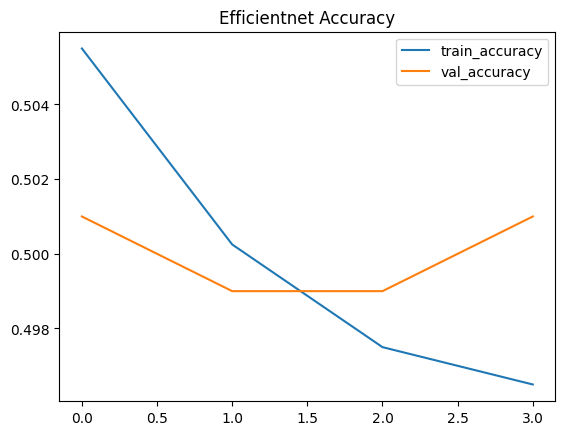

In [57]:
plt.plot(history_ef.history['accuracy'])
plt.plot(history_ef.history['val_accuracy'])
plt.title('Efficientnet Accuracy')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

In [58]:
Y_pred = efficientnet_model.predict(X_test)

157/157 ━━━━━━━━━━━━━━━━━━━━ 23s 89ms/step


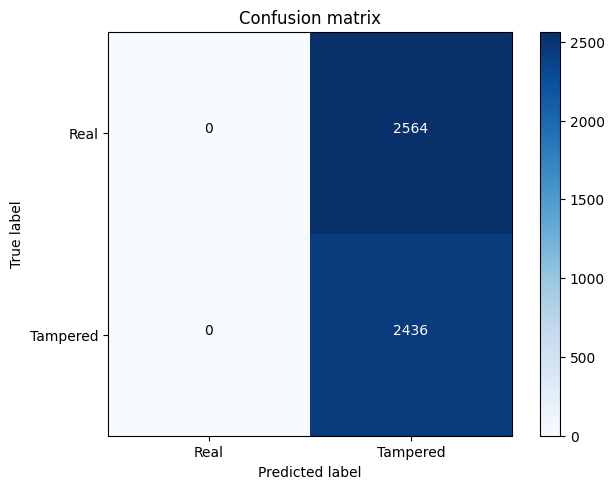

In [59]:
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
Y_true = np.argmax(Y_test,axis = 1) 
eff_confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
plot_confusion_matrix(eff_confusion_mtx, classes = ['Real','Tampered'])

# ResNet

In [60]:
from tensorflow.keras.applications import ResNet50

In [61]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
x= base_model.output
x = GlobalAveragePooling2D()(x)  

#fully connected layer
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)  # 
x = Dropout(0.4)(x)  # Dropout for regularization

# fully connected layer 
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

# final output layer 
output = Dense(2, activation='softmax')(x)

# final model
res_model = Model(inputs=base_model.input, outputs=output)

# Compile the model 
res_model.compile(optimizer=Adam(learning_rate=0.001), 
                       loss='categorical_crossentropy', 
                       metrics=['accuracy'])

In [63]:
res_model.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 134, 134,  │          0 │ input_layer_4[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 64, 64,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 64, 64,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 64, 64,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 66, 66,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 32, 32,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 32, 32,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 32, 32,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 32, 32,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 32, 32,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 32, 32,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 32, 32,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 32, 32,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 32, 32,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 32, 32,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 32, 32,    │      1,024 │ conv2_block1_3_c

 Total params: 24,771,714 (94.50 MB)

 Trainable params: 24,717,058 (94.29 MB)

 Non-trainable params: 54,656 (213.50 KB)

In [64]:
history_res = res_model.fit(
    X_train, Y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_val, Y_val), callbacks=[EarlyStopping(patience=1)]
)

Epoch 1/50


I0000 00:00:1730364073.158587     133 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_32', 20 bytes spill stores, 20 bytes spill loads



125/125 ━━━━━━━━━━━━━━━━━━━━ 85s 174ms/step - accuracy: 0.8302 - loss: 0.4596 - val_accuracy: 0.5010 - val_loss: 1.4310
Epoch 2/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 15s 117ms/step - accuracy: 0.9020 - loss: 0.2403 - val_accuracy: 0.5010 - val_loss: 0.7521
Epoch 3/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 14s 115ms/step - accuracy: 0.9212 - loss: 0.2205 - val_accuracy: 0.4990 - val_loss: 0.7032
Epoch 4/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 14s 115ms/step - accuracy: 0.9290 - loss: 0.1826 - val_accuracy: 0.4990 - val_loss: 0.7775


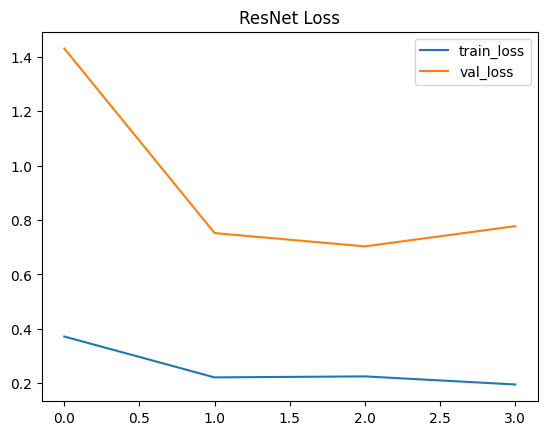

In [65]:
plt.plot(history_res.history['loss'])
plt.plot(history_res.history['val_loss'])
plt.title('ResNet Loss')
plt.legend(['train_loss', 'val_loss'])
plt.show()

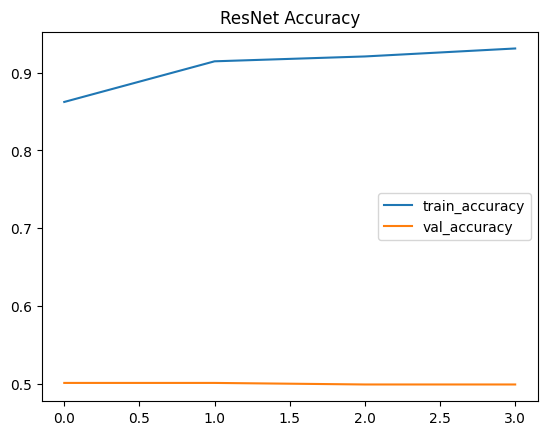

In [66]:
plt.plot(history_res.history['accuracy'])
plt.plot(history_res.history['val_accuracy'])
plt.title('ResNet Accuracy')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

In [67]:
X_test = np.load('ELA_Data/X_test.npy')
Y_test = np.load('ELA_Data/Y_test.npy')

In [ ]:
from sklearn.metrics import confusion_matrix

#predictions on the testing data 
Y_pred = res_model.predict(X_test)

157/157 ━━━━━━━━━━━━━━━━━━━━ 11s 49ms/step


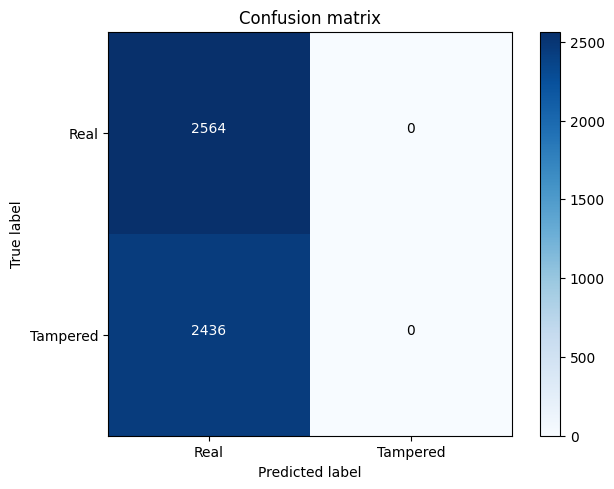

In [69]:
#argmax idx among class 0 and 1
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
Y_true = np.argmax(Y_test,axis = 1) 
res_confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
plot_confusion_matrix(res_confusion_mtx, classes = ['Real','Tampered'])

# GoogLeNet

In [70]:
from tensorflow.keras.applications import InceptionV3

In [71]:
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(128, 128, 3))


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
x = base_model.output
x = GlobalAveragePooling2D()(x)  
x = Dropout(0.4)(x)  # dropout to reduce overfitting
x = Dense(1024, activation='relu')(x)  # Fully connected layer

In [73]:
# Final classification layer
predictions = Dense(2, activation='softmax')(x)

In [74]:
# Create the complete model
model_in = Model(inputs=base_model.input, outputs=predictions)

In [75]:
for layer in base_model.layers:
    layer.trainable = False


In [76]:
model_in.compile(optimizer=SGD(learning_rate=1e-4, momentum=0.95, nesterov=False), loss='categorical_crossentropy', metrics=['accuracy'])

In [77]:
model_in.summary()


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 63, 63,    │        864 │ input_layer_5[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 63, 63,    │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 63, 63,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 61, 61,    │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 61, 61,    │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 61, 61,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 61, 61,    │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 61, 61,    │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 61, 61,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 30, 30,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 30, 30,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 30, 30,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 30, 30,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 28, 28,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 28, 28,    │          0 │ batch_normalizat

 Total params: 23,903,010 (91.18 MB)

 Trainable params: 2,100,226 (8.01 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [78]:
history_in = model_in.fit(X_train, Y_train, epochs=10, validation_data=(X_val, Y_val))



Epoch 1/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 30s 117ms/step - accuracy: 0.5346 - loss: 0.8739 - val_accuracy: 0.7280 - val_loss: 0.5520
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.7137 - loss: 0.5955 - val_accuracy: 0.7570 - val_loss: 0.5076
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.7412 - loss: 0.5295 - val_accuracy: 0.7690 - val_loss: 0.4950
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.7647 - loss: 0.5011 - val_accuracy: 0.7840 - val_loss: 0.4785
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.7745 - loss: 0.4885 - val_accuracy: 0.7920 - val_loss: 0.4638
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.8010 - loss: 0.4524 - val_accuracy: 0.7960 - val_loss: 0.4552
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.8088 - loss: 0.4348 - val_accuracy: 0.7990 - val_loss: 0.4473
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.8024 - loss: 0.4308 - val_ac

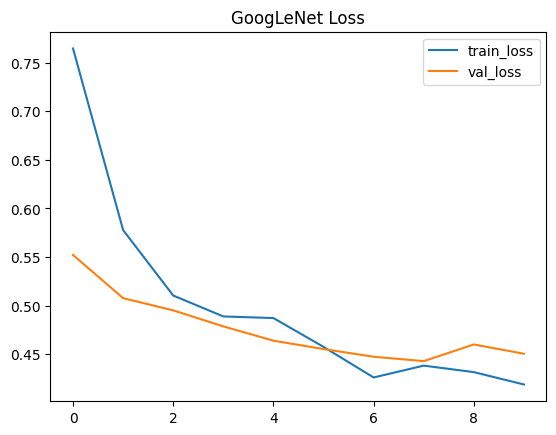

In [79]:
plt.plot(history_in.history['loss'])
plt.plot(history_in.history['val_loss'])
plt.title('GoogLeNet Loss')
plt.legend(['train_loss', 'val_loss'])
plt.show()

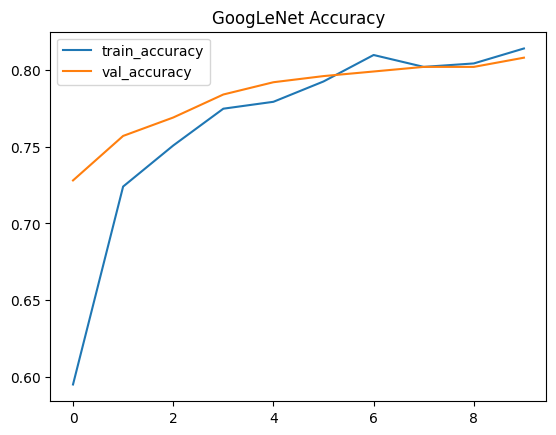

In [80]:
plt.plot(history_in.history['accuracy'])
plt.plot(history_in.history['val_accuracy'])
plt.title('GoogLeNet Accuracy')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

In [81]:
Y_pred = model_in.predict(X_test)

157/157 ━━━━━━━━━━━━━━━━━━━━ 13s 52ms/step


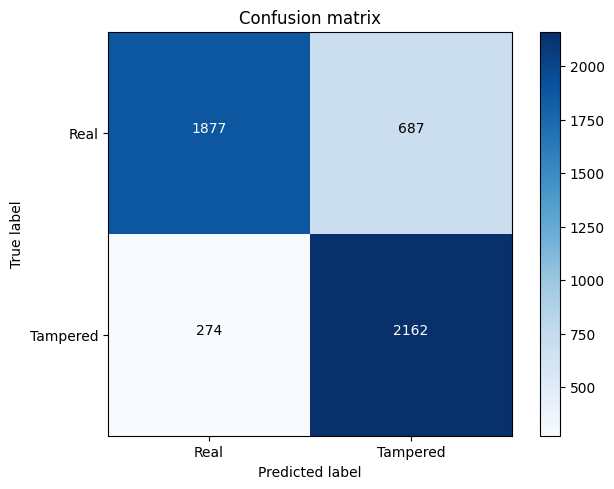

In [82]:
#argmax idx among class 0 and 1
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
Y_true = np.argmax(Y_test,axis = 1) 
in_confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
plot_confusion_matrix(in_confusion_mtx, classes = ['Real','Tampered'])

In [83]:
import pandas as pd

def calculate_metrics(confusion_matrices, model_names):
    metrics = []

    # Loop through each confusion matrix
    for i, cm in enumerate(confusion_matrices):
        # Unpack the confusion matrix
        TP, FP = cm[0]
        FN, TN = cm[1]

        # Calculate metrics
        accuracy = (TP + TN) / (TP + FP + FN + TN)
        precision = TP / (TP + FP) if (TP + FP) != 0 else 0
        recall = TP / (TP + FN) if (TP + FN) != 0 else 0
        f1_score = (2 * precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

        # Append the results
        metrics.append([model_names[i], accuracy, precision, recall, f1_score])

    # Dataframe to display results 
    results_df = pd.DataFrame(metrics, columns=["Model", "Accuracy", "Precision", "Recall", "F1 Score"])
    return results_df

confusion_matrices = [
    densenet_confusion_mtx,vgg_confusion_mtx,eff_confusion_mtx,res_confusion_mtx,in_confusion_mtx]

model_names = ["DenseNet121", "VGG16", "EfficientNet", "ResNet50", "GoogLeNet"]

results_df = calculate_metrics(confusion_matrices, model_names)
print(results_df)


          Model  Accuracy  Precision    Recall  F1 Score
0   DenseNet121    0.9382   0.913027  0.964565  0.938089
1         VGG16    0.8972   0.905616  0.895143  0.900349
2  EfficientNet    0.4872   0.000000  0.000000  0.000000
3      ResNet50    0.5128   1.000000  0.512800  0.677948
4     GoogLeNet    0.8078   0.732059  0.872617  0.796182
